In [1]:
import numpy as np
import torch
from src import kernel_flow, datagen
import tqdm
import matplotlib.pyplot as plt

# Lorenz

## Regular time steps

In [5]:
# generate dataset
Data = datagen.Lorenz(T=100, dt=0.01,s=10,r=28,b = 10/3, N_sims=1)[0]
#train test split
observed_data= Data
train_data = Data[:5000,:].T
test_data = Data[5000:,:].T

# Some constants
nparameters=24
delay = 2
regu_lambda = 0.00001
lr = 0.01

# Get scaling factor
normalize=np.amax(train_data[:,:])

X_train, Y_train = datagen.prepare_data_fast(train_data,delay,normalize)
X_test, Y_test = datagen.prepare_data_fast(test_data,delay,normalize)

model = kernel_flow.KernelFlows("anl3", nparameters = nparameters, regu_lambda = regu_lambda, dim = 3, metric = "rho_ratio", batch_size = 100)
model,rho_list = kernel_flow.train_kernel(X_train, Y_train, model, lr = lr)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 65.49it/s]


In [6]:
model.compute_kernel_and_inverse(regu_lambda = regu_lambda)

horizon = 20

Y_pred = model.predict_ahead(X_test,horizon=horizon, delay = delay, delta_t_mode = False)

mse_pred = (Y_pred.detach()-Y_test).pow(2).mean()
r2 = 1-mse_pred/Y_test.var()

print(f"MSE On test : {mse_pred:.4f} - R2 : {r2:.4f}")

MSE On test : 0.0000


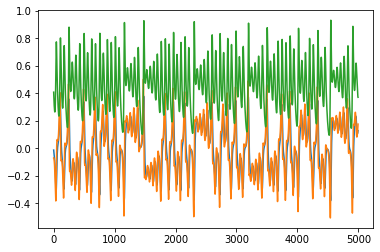

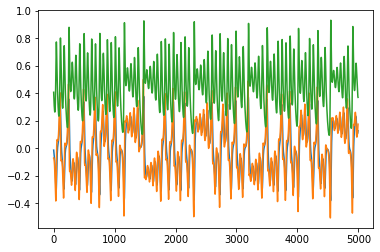

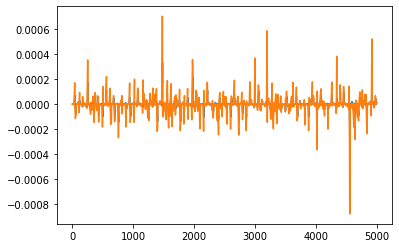

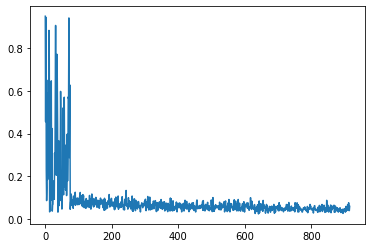

In [7]:
plt.plot(Y_pred[:,:].detach())
plt.figure()
plt.plot(Y_test[:,:])
plt.figure()
plt.plot(Y_pred[:,0].detach()-Y_test[:,0])
plt.plot(Y_pred[:,1].detach()-Y_test[:,1])
plt.figure()
plt.plot(rho_list)

### n steps interval

In [9]:
n = 3

# generate dataset
Data = datagen.Lorenz(T=100, dt=0.01,s=10,r=28,b = 10/3, N_sims=1)[0]
#train test split
observed_data= Data[0::n]
train_data = Data[:5000,:].T
test_data = Data[5000:,:].T

# Some constants
nparameters=24
delay = 2
regu_lambda = 0.00001
lr = 0.01

# Get scaling factor
normalize=np.amax(train_data[:,:])

X_train, Y_train = datagen.prepare_data_fast(train_data,delay,normalize)
X_test, Y_test = datagen.prepare_data_fast(test_data,delay,normalize)

model = kernel_flow.KernelFlows("anl3", nparameters = nparameters, regu_lambda = regu_lambda, dim = 3, metric = "rho_ratio", batch_size = 100)
model,_ = kernel_flow.train_kernel(X_train, Y_train, model, lr = lr)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 64.84it/s]


In [10]:
model.compute_kernel_and_inverse(regu_lambda = regu_lambda)

horizon = 20

Y_pred = model.predict_ahead(X_test,horizon=horizon, delay = delay, delta_t_mode = False)

mse_pred = (Y_pred.detach()-Y_test).pow(2).mean()
r2 = 1-mse_pred/Y_test.var()

print(f"MSE On test : {mse_pred:.4f} - R2 : {r2:.4f}")

MSE On test : 0.0000


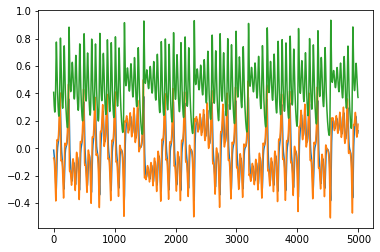

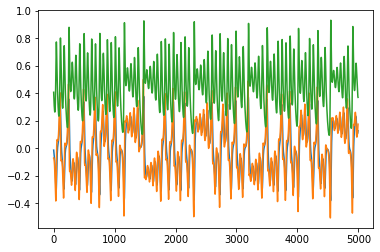

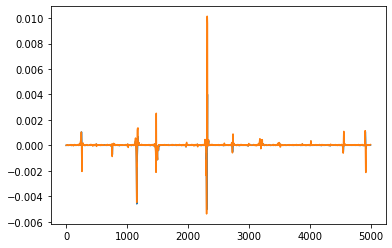

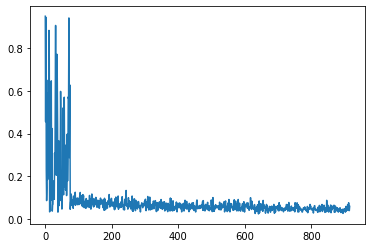

In [11]:
plt.plot(Y_pred[:,:].detach())
plt.figure()
plt.plot(Y_test[:,:])
plt.figure()
plt.plot(Y_pred[:,0].detach()-Y_test[:,0])
plt.plot(Y_pred[:,1].detach()-Y_test[:,1])
plt.figure()
plt.plot(rho_list)

# Irregular Sampling


## Data Generation

In [22]:
max_delay = 5
N_points = 10000
train_n = 5000
burnin = 200
dt = 0.01

delays = np.random.randint(max_delay,size=N_points-1)+1
indices = np.concatenate((np.zeros(1),np.cumsum(delays))).astype(int)
delays = np.concatenate((delays,np.zeros(1))).astype(int)

max_idx = indices[-1]
T = np.ceil(max_idx*dt)

# generate dataset
Data = datagen.Lorenz(T=T+burnin*dt, dt=dt,s=10,r=28,b = 10/3, N_sims=1)[0][burnin:]

#times
observed_data = Data[indices]

train_data = observed_data[:train_n,:].T
test_data = observed_data[train_n:,:].T
delays_train = delays[:train_n]
delays_test = delays[train_n:]

## Classical Kernel Flow

In [33]:
# Some constants
nparameters=24
delay = 2
regu_lambda = 0.00001
lr = 0.01

# Get scaling factor
normalize=np.amax(train_data[:,:])

X_train, Y_train = datagen.prepare_data_fast(train_data,delay,normalize)
X_test, Y_test = datagen.prepare_data_fast(test_data,delay,normalize)

model = kernel_flow.KernelFlows("anl3", nparameters = nparameters, regu_lambda = regu_lambda, dim = 3, metric = "rho_ratio", batch_size = 100)

model, rho_list  = kernel_flow.train_kernel(X_train, Y_train, model, lr = lr, epochs = 1000)

0it [00:00, ?it/s]


In [34]:
model.compute_kernel_and_inverse(regu_lambda = regu_lambda)

horizon = 1

Y_pred = model.predict_ahead(X_test,horizon=horizon, delay = delay, delta_t_mode = False)

mse_pred = (Y_pred.detach()-Y_test).pow(2).mean()
r2 = 1-mse_pred/Y_test.var()

print(f"MSE On test : {mse_pred:.4f} - R2 : {r2:.4f}")

MSE On test : 48.6645 - R2 : -559.6016


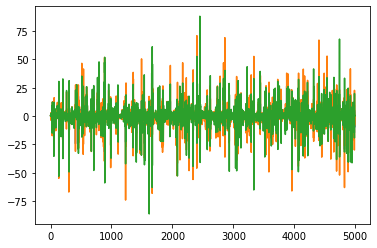

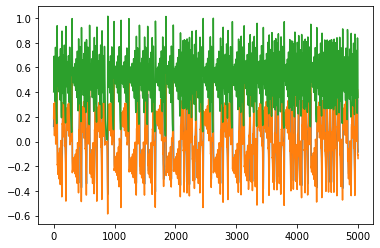

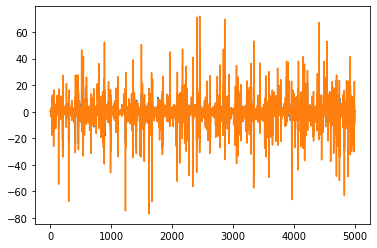

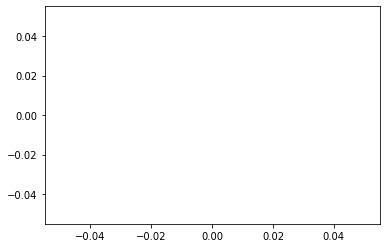

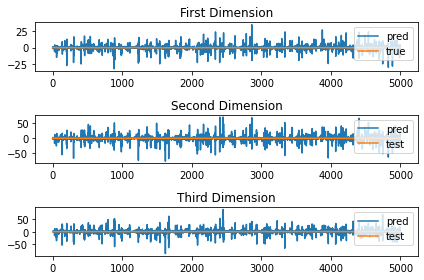

In [35]:
plt.plot(Y_pred[:,:].detach())
plt.figure()
plt.plot(Y_test[:,:])
plt.figure()
plt.plot(Y_pred[:,0].detach()-Y_test[:,0])
plt.plot(Y_pred[:,1].detach()-Y_test[:,1])
plt.figure()
plt.plot(rho_list)

fig, ax = plt.subplots(3,1)
ax[0].plot(Y_pred[:,0].detach(),label = "pred")
ax[0].plot(Y_test[:,0], label = "true")
ax[0].set_title("First Dimension")
ax[0].legend(loc = "upper right")

ax[1].plot(Y_pred[:,1].detach(),label = "pred")
ax[1].plot(Y_test[:,1], label = "test")
ax[1].set_title("Second Dimension")
ax[1].legend(loc = "upper right")

ax[2].plot(Y_pred[:,2].detach(),label = "pred")
ax[2].plot(Y_test[:,2], label = "test")
ax[2].set_title("Third Dimension")
ax[2].legend(loc = "upper right")

fig.tight_layout()

/home/edward/.cache/pypoetry/virtualenvs/kernel-flows-9viWSso2-py3.8/lib/python3.8/site-packages/mpl_toolkits/mplot3d/proj3d.py:136: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([xs, ys, zs, np.ones_like(xs)])
/home/edward/.cache/pypoetry/virtualenvs/kernel-flows-9viWSso2-py3.8/lib/python3.8/site-packages/mpl_toolkits/mplot3d/proj3d.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype

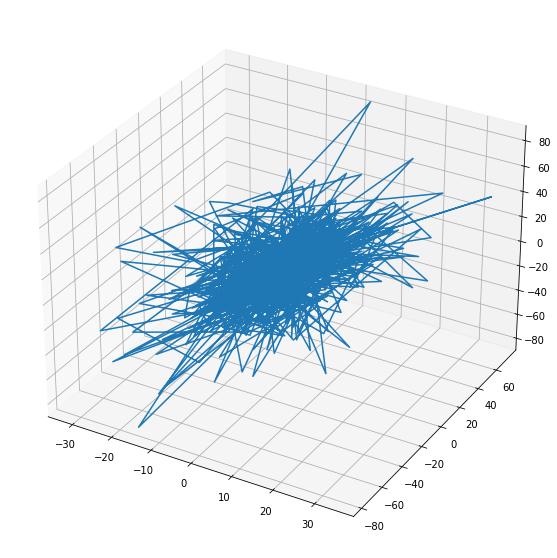

In [36]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
#ax.plot(Y_test[:,0],Y_test[:,1],Y_test[:,2])
ax.plot(Y_pred[:,0].detach(),Y_pred[:,1].detach(),Y_pred[:,2].detach())

## Irregular Kernel Flows

In [9]:
# Some constants
nparameters=24
delay = 2
regu_lambda = 0.00001
lr = 0.01

# Get scaling factor
normalize=np.amax(train_data[:,:])

X_train, Y_train = datagen.prepare_data_fast(train_data,delay,normalize, delays_train)
X_test, Y_test = datagen.prepare_data_fast(test_data,delay,normalize, delays_test)

model = kernel_flow.KernelFlows("anl3", nparameters = nparameters, regu_lambda = regu_lambda, dim = 3, metric = "rho_ratio", batch_size = 100)

model, rho_list  = kernel_flow.train_kernel(X_train, Y_train, model, lr = lr)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 50.19it/s]


In [10]:
model.compute_kernel_and_inverse(regu_lambda = regu_lambda)

horizon = 20

Y_pred = model.predict_ahead(X_test,horizon=horizon, delay = delay, delta_t_mode = True)

mse_pred = (Y_pred.detach()-Y_test).pow(2).mean()
r2 = 1-mse_pred/Y_test.var()

print(f"MSE On test : {mse_pred:.4f} - R2 : {r2:.4f}")

MSE On test : 0.0014 - R2 : 0.9837


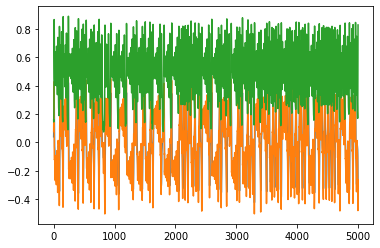

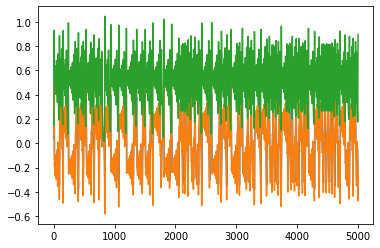

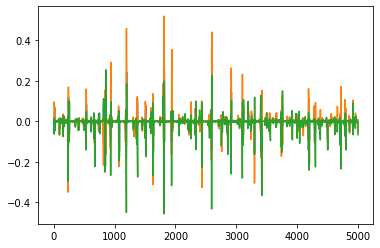

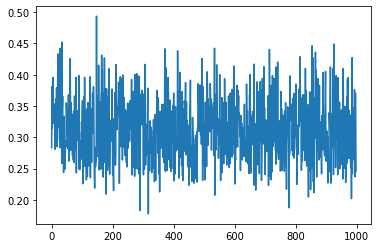

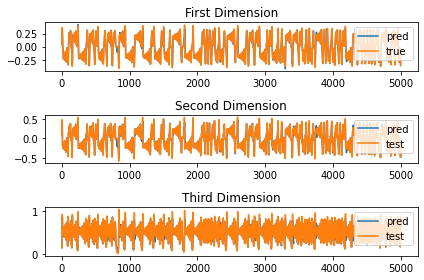

In [13]:
plt.plot(Y_pred[:,:].detach())
plt.figure()
plt.plot(Y_test[:,:])
plt.figure()
plt.plot(Y_pred[:,0].detach()-Y_test[:,0])
plt.plot(Y_pred[:,1].detach()-Y_test[:,1])
plt.plot(Y_pred[:,2].detach()-Y_test[:,2])
plt.figure()
plt.plot(rho_list)

fig, ax = plt.subplots(3,1)
ax[0].plot(Y_pred[:,0].detach(),label = "pred")
ax[0].plot(Y_test[:,0], label = "true")
ax[0].set_title("First Dimension")
ax[0].legend(loc = "upper right")

ax[1].plot(Y_pred[:,1].detach(),label = "pred")
ax[1].plot(Y_test[:,1], label = "test")
ax[1].set_title("Second Dimension")
ax[1].legend(loc = "upper right")

ax[2].plot(Y_pred[:,2].detach(),label = "pred")
ax[2].plot(Y_test[:,2], label = "test")
ax[2].set_title("Third Dimension")
ax[2].legend(loc = "upper right")
fig.tight_layout()

/home/edward/.cache/pypoetry/virtualenvs/kernel-flows-9viWSso2-py3.8/lib/python3.8/site-packages/mpl_toolkits/mplot3d/proj3d.py:136: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([xs, ys, zs, np.ones_like(xs)])
/home/edward/.cache/pypoetry/virtualenvs/kernel-flows-9viWSso2-py3.8/lib/python3.8/site-packages/mpl_toolkits/mplot3d/proj3d.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype

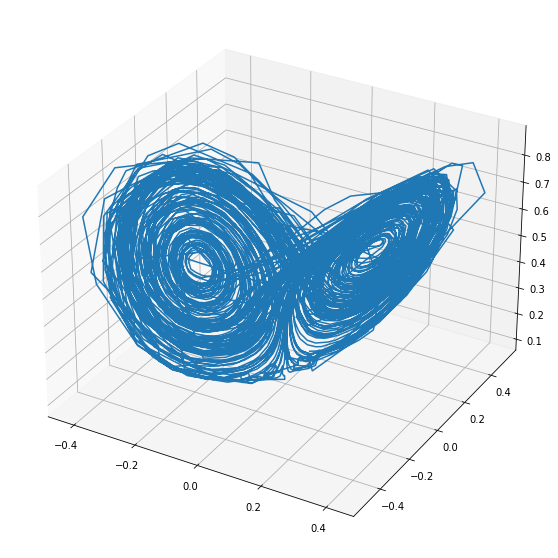

In [12]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
#ax.plot(Y_test[:,0],Y_test[:,1],Y_test[:,2])
ax.plot(Y_pred[:,0].detach(),Y_pred[:,1].detach(),Y_pred[:,2].detach())